In [49]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
import seaborn as sns 
from utils import load_ncbi_genome_metadata
import src.download as download
import src.tools as tools
from src import get_genome_id
import glob
from matplotlib.gridspec import GridSpec
from src.files import FASTAFile, InterProScanFile
from tqdm import tqdm
from src.reference import compare, annotate, reverse_complement
import src.reference as reference
import matplotlib as mpl 
from sklearn.linear_model import LinearRegression
from src.download import NCBI
import re 
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare

%load_ext autoreload 
%autoreload 2

get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dataset_df = annotate(dataset_df)
all_hits_df = annotate(all_hits_df, prefix='subject')

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

In [9]:
# First, want to confirm that the predicted proteins are actually out-of-sample. 
# Align the sequences to the SwissProt database. Might also be worth aligning against UniRef50, or doing a full BLAST
# search of the matches to see how many align to sequences that the underlying PLM might have been trained on. 

matches_df = dataset_df[dataset_df.match].copy()
swissprot_df = pd.read_csv('../data/dataset/swissprot_bacteria.csv', index_col=0)

mmseqs = tools.MMSeqs()
matches_align_df = mmseqs.align(matches_df, subject_df=swissprot_df, query_name='matches', subject_name='swissprot', output_dir='../data/results/results-2/', overwrite=False)
matches_with_alignment = matches_align_df[matches_align_df.bit_score > 50].query_id.unique()

In [10]:
n_unsupported_matches_with_alignment = matches_df.loc[matches_with_alignment].top_hit_unsupported.sum()
n_confirmed_matches_with_alignment = (~matches_df.loc[matches_with_alignment].top_hit_unsupported).sum()
n_matches_with_alignment = len(matches_with_alignment)

total_matches = len(matches_df)
total_unsupported_matches = matches_df.top_hit_unsupported.sum()
total_confirmed_matches = (~matches_df.top_hit_unsupported).sum()

print('Num. matches with a significant alignment:', n_matches_with_alignment, f'({get_percent(n_matches_with_alignment, total_matches)})')
print('Num. unsupported matches with a significant alignment:', n_unsupported_matches_with_alignment, f'({get_percent(n_unsupported_matches_with_alignment, total_unsupported_matches)})')
print('Num. confirmed matches with a significant alignment:', n_confirmed_matches_with_alignment, f'({get_percent(n_confirmed_matches_with_alignment, total_confirmed_matches)})')

Num. matches with a significant alignment: 31716 (64.17%)
Num. unsupported matches with a significant alignment: 160 (2.54%)
Num. confirmed matches with a significant alignment: 31556 (73.19%)


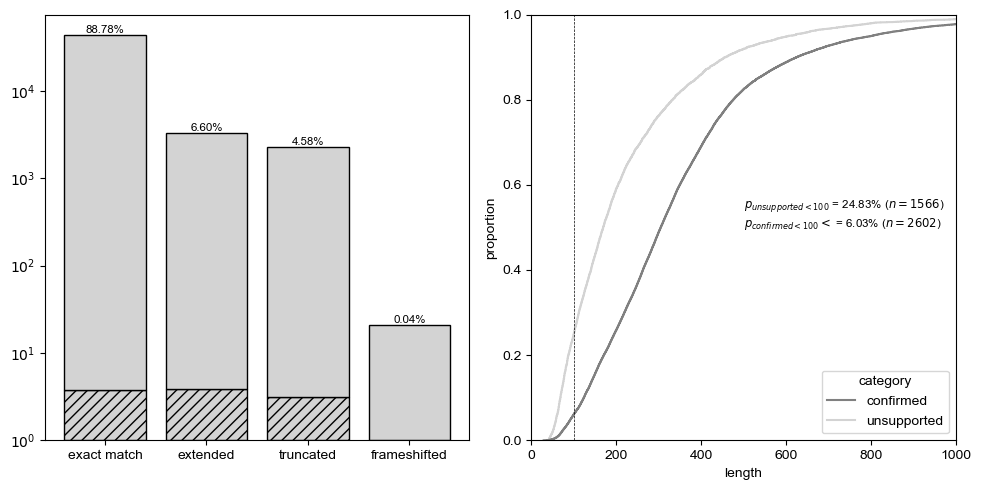

In [11]:
def si_figure_1(dataset_df:pd.DataFrame):

    figure_df = dataset_df[dataset_df.match].copy()
    figure_df['category'] = np.select([figure_df.extended, figure_df.truncated, figure_df.exact_match, figure_df.top_hit_frameshifted], ['extended', 'truncated', 'exact match', 'frameshifted'], default='none')

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax_a_df = pd.DataFrame(index=figure_df.category.unique())
    ax_a_df['total'] = figure_df.category.value_counts()
    ax_a_df['log_total'] = np.log10(ax_a_df['total'])
    ax_a_df['fraction'] = figure_df.groupby('category').apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
    ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
    ax_a_df['confirmed'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

    positions = np.arange(figure_df.category.nunique())
    ax_a.bar(positions, ax_a_df.unsupported, color='lightgray', edgecolor='black', hatch='///')
    ax_a.bar(positions, ax_a_df.confirmed, bottom=ax_a_df.unsupported, color='lightgray', edgecolor='black')

    ax_a.set_xticks(positions, labels=ax_a_df.index)
    ax_a.set_yticks(np.arange(5), labels=[f'$10^{i}$' for i in range(5)])

    for x, total, log_total in zip(positions, ax_a_df.total, ax_a_df.log_total):
        text = f'{100 * total / ax_a_df.total.sum():.2f}%'
        ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')


    palette = {'unsupported':'lightgray', 'confirmed':'gray'}
    ax_b_df = figure_df.copy()
    ax_b_df['category'] = np.where(ax_b_df.top_hit_unsupported, 'unsupported', 'confirmed') 

    sns.ecdfplot(data=ax_b_df, ax=ax_b, x='length', hue='category', palette=palette)
    ax_b.set_ylabel('proportion')
    ax_b.set_xlim(xmax=1000, xmin=0)

    n_unsupported_smorfs = ((ax_b_df.length < 100) & (ax_b_df.top_hit_unsupported)).sum()
    n_confirmed_smorfs = ((ax_b_df.length < 100) & (~ax_b_df.top_hit_unsupported)).sum()
    total_unsupported = ax_b_df.top_hit_unsupported.sum()
    total_confirmed = (~ax_b_df.top_hit_unsupported).sum()
    text = '$p_{unsupported<100}$' + f' = {get_percent(n_unsupported_smorfs, total_unsupported)} ($n={n_unsupported_smorfs}$)\n'
    text += '$p_{confirmed<100}<$' + f' = {get_percent(n_confirmed_smorfs, total_confirmed)} ($n={n_confirmed_smorfs}$)'
    ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=100, ls='--', color='black', lw=0.5)
    fig.tight_layout()
    plt.show()

    plt.show()

# I don't know if the middle panel is necessary, maybe should just talk about the extension and truncation in a later section. 
si_figure_1(dataset_df)

In [12]:
match_extended_mask = (dataset_df.match) & (dataset_df.extended)

total_extended = match_extended_mask.sum()
n_extended_less_than_30_bp = (match_extended_mask & ((dataset_df.length - dataset_df.top_hit_length) < 10)).sum()
n_extended_less_than_60_bp = (match_extended_mask & ((dataset_df.length - dataset_df.top_hit_length) < 20)).sum()
n_extended_less_than_90_bp = (match_extended_mask & ((dataset_df.length - dataset_df.top_hit_length) < 30)).sum()

print('Num. extensions < 30 bp:', n_extended_less_than_30_bp, f'({get_percent(n_extended_less_than_30_bp, total_extended)})')
print('Num. extensions < 60 bp:', n_extended_less_than_60_bp, f'({get_percent(n_extended_less_than_60_bp, total_extended)})')
print('Num. extensions < 90 bp:', n_extended_less_than_90_bp, f'({get_percent(n_extended_less_than_90_bp, total_extended)})')

Num. extensions < 30 bp: 1353 (41.45%)
Num. extensions < 60 bp: 2191 (67.13%)
Num. extensions < 90 bp: 2602 (79.72%)


In [ ]:

is_cds_conflict = lambda df : (df.conflict) & (df.top_hit_feature == 'CDS') & (~df.top_hit_pseudo)
is_non_coding_conflict = lambda df : df.conflict & (df.top_hit_feature != 'CDS')

In [14]:
interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
ids_with_antifam_hit = interpro_df[interpro_df.interpro_analysis == 'AntiFam'].index.unique()
ids_with_antifam_hit = np.intersect1d(ids_with_antifam_hit, dataset_df.index) # Make sure to remove AntiFam hits from the excluded genomes.
dataset_df['antifam_hit'] = dataset_df.index.isin(ids_with_antifam_hit)

antifam_interpro_df = interpro_df.loc[ids_with_antifam_hit].sort_values('interpro_e_value')
antifam_interpro_df = antifam_interpro_df[~antifam_interpro_df.index.duplicated(keep='first')].copy()

print('Num. proteins with AntiFam hit:', len(ids_with_antifam_hit))
for description, df in antifam_interpro_df.groupby('interpro_signature_description'):
    description = description[0].lower() + description[1:]
    print(f'\tNum. {description}:', len(df))

Num. proteins with AntiFam hit: 27
	Num. antisense to 23S rRNA: 5
	Num. antisense to RNaseP: 2
	Num. translation of CRISPR region: 9
	Num. tRNA translation: 11


**SI Figure 3.2.2.** 

**(A)** Summary of the reference features conflicting with the Prodigal-predicted sequences. The hatched region indicates the fraction which could be annotated by AntiFam. 

**(B)** ECDF curves for of the overlap lengths of the sequences which conflict with supported (solid lines) and unsupported (dotted lines) CDS in either orientation. Antisense conflicts are significantly larger than sense conflicts for both supported and unsupported CDS ($p_{supported} < $, $p_{unsupported} < $). Additionally, conflicts with unsupported CDS are significantly larger than those with supported CDS, controlling for orientation ($p_{sense} < $, $p_{antisense} < $). 

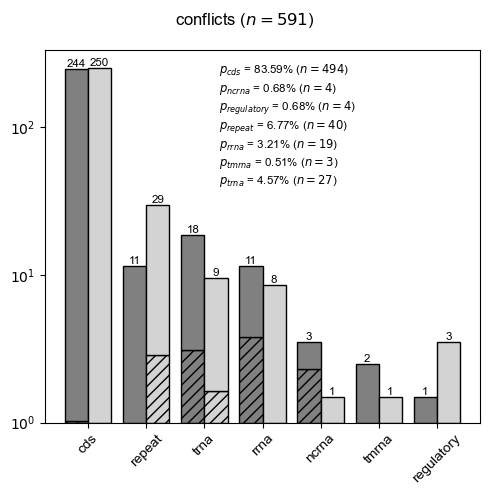

In [15]:
def si_figure_2(dataset_df:pd.DataFrame):

    figure_df = dataset_df[dataset_df.conflict][['top_hit_feature', 'same_strand', 'top_hit_unsupported', 'overlap_length', 'antifam_hit', 'query_overlap_fraction']].copy()
    
    masks = dict()
    masks['cds'] = figure_df.top_hit_feature == 'CDS'
    masks['trna'] = figure_df.top_hit_feature == 'tRNA'
    masks['rrna'] = figure_df.top_hit_feature == 'rRNA'
    masks['tmrna'] = figure_df.top_hit_feature == 'tmRNA'
    masks['ncrna'] = figure_df.top_hit_feature == 'ncRNA'
    masks['repeat'] = figure_df.top_hit_feature == 'repeat_region'
    masks['regulatory'] = figure_df.top_hit_feature == 'regulatory'

    categories = ['cds', 'repeat', 'trna', 'rrna', 'ncrna',  'tmrna', 'regulatory']
    conditions = [masks[category] for category in categories]
    figure_df['category'] = np.select(conditions, categories, default='none')

    fig, ax_a = plt.subplots(figsize=(5, 5)) #, width_ratios=[0.6, 0.4])
    
    width = 0.4
    offsets = {True:width/2, False:-width/2}
    palette = {True:'lightgray', False:'gray'}
        
    positions = np.arange(figure_df.category.nunique())

    for same_strand, df in figure_df.groupby('same_strand'):
        ax_a_df = pd.DataFrame(index=categories)
        ax_a_df['total'] = df.category.value_counts()
        ax_a_df['log_total'] = np.log10(ax_a_df['total'] + 0.5)
        ax_a_df['fraction'] = df.groupby('category').apply(lambda df : df.antifam_hit.sum() / len(df), include_groups=False)
        ax_a_df['antifam_hit'] = ax_a_df['log_total'] * ax_a_df['fraction']
        ax_a_df['no_antifam_hit'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

        ax_a.bar(positions + offsets[same_strand], ax_a_df.antifam_hit, color=palette[same_strand], edgecolor='black', hatch='///', width=width)
        ax_a.bar(positions + offsets[same_strand], ax_a_df.no_antifam_hit, bottom=ax_a_df.antifam_hit, color=palette[same_strand], edgecolor='black', width=width)
        
        for x, total, log_total in zip(positions + offsets[same_strand], ax_a_df.total, ax_a_df.log_total):
            # text = f'{100 * total / ax_a_df.total.sum():.2f}%'
            text = str(total)
            ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

    ax_a.set_xticks(positions, labels=ax_a_df.index, rotation=45)
    ax_a.set_yticks(np.arange(3), labels=[f'$10^{i}$' for i in range(3)])

    text = ''
    for category, df in figure_df.groupby('category'):
        text += '$p_{' + category + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    ax_a.text(0.4, 0.6, text, transform=ax_a.transAxes, fontsize='small')

    fig.suptitle(f'conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

si_figure_2(dataset_df)

In [ ]:
print('Num. conflicts with non-coding elements:', is_non_coding_conflict(dataset_df).sum())
print('Num. nested conflicts with non-coding elements:', (is_non_coding_conflict(dataset_df) & (dataset_df.overlap_type == 'nested')).sum())
print('Num. conflicts with non-coding elements where the query is completely contained within the non-coding gene:', (is_non_coding_conflict(dataset_df) & (dataset_df.query_overlap_fraction == 1)).sum())
print('Num. conflicts with non-coding elements where the non-coding gene is completely contained within the query:', (is_non_coding_conflict(dataset_df) & (dataset_df.top_hit_overlap_fraction == 1)).sum())

Num. conflicts with non-coding elements: 97
Num. nested conflicts with non-coding elements: 82
Num. conflicts with non-coding elements where the query is completely contained within the non-coding gene: 55
Num. conflicts with non-coding elements where the non-coding gene is completely contained within the query: 27


In [ ]:
print('Num. sequences which conflict with > 1 reference element:', ((dataset_df.conflict) & (dataset_df.n_hits > 1)).sum())
print('Num. sequences which conflict with > 2 reference elements:', ((dataset_df.conflict) & (dataset_df.n_hits > 2)).sum(), end='\n\n')

all_hits_df = annotate(all_hits_df, prefix='subject')
conflict_ids = dataset_df[(dataset_df.conflict) & (dataset_df.top_hit_feature == 'CDS') & (dataset_df.n_hits > 1)].index

# Seems as though all but two sequences only conflict with other CDS. I think these can mostly be ignored, but probably an increased likelihood
# that these sequences are spurious. 
for id_, df in all_hits_df[all_hits_df.query_id.isin(conflict_ids)].groupby('query_id'):
    if not np.all(df.subject_feature == 'CDS'):
        print(f'Expected all conflicts to be with CDS, but {id_} conflicts with: ' + ', '.join(df.subject_feature))
    if not np.all(df.conflict): # Making sure no matches snuck in. 
        print(f'Expected all conflicting sequences to only conflict with the reference, but {id_} has hits annotated as: ' + ', '.join(df.category))


Num. sequences which conflict with > 1 reference element: 96
Num. sequences which conflict with > 2 reference elements: 6

Expected all conflicts to be with CDS, but NZ_CP130454.1_3215 conflicts with: regulatory, CDS
Expected all conflicts to be with CDS, but NZ_QXIU01000103.1_3 conflicts with: CDS, tRNA, tRNA, tRNA, CDS
Expected all conflicting sequences to only conflict with the reference, but NZ_QXIU01000190.1_5 has hits annotated as: pseudogene, conflict, conflict


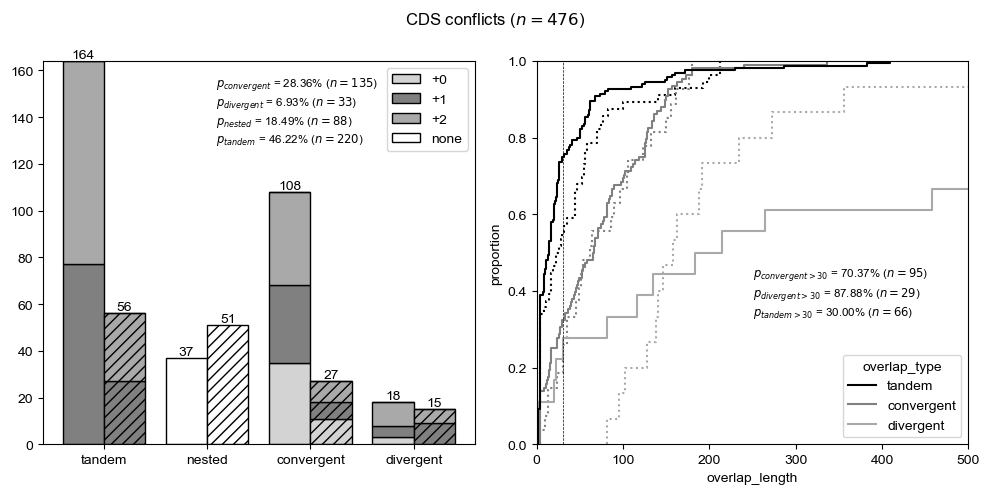

In [122]:
# TODO: Check the overlap lengths for different frames. 

def si_figure_2(dataset_df:pd.DataFrame, exclude_nested:bool=False):
    figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    figure_df = figure_df[figure_df.overlap_type != 'nested'].copy() if exclude_nested else figure_df
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    phase_map = {'divergent':'phase_start', 'convergent':'phase_stop', 'tandem':'phase_start'}
    figure_df['phase'] = ['none' if (row.overlap_type == 'nested') else '+' + str(getattr(row, phase_map[row.overlap_type])) for row in figure_df.itertuples()]

    palette = {'+0':'lightgray', '+1':'gray', '+2':'darkgray', 'none':'white'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for phase, df in ax_df.groupby('phase'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax_a.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=phase if add_label else None, color=palette[phase], width=width, hatch=hatch)
            bottom += np.array(heights)
            totals += heights
        for x, y in zip(positions + offset, totals):
            ax_a.text(x, y, str(int(y)), ha='center', va='bottom')

    panel_a(figure_df[~figure_df.top_hit_unsupported], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_unsupported], offset=width/2, hatch='///', add_label=False)

    text = ''
    for overlap_type, df in figure_df.groupby('overlap_type'):
        text += '$p_{' + overlap_type + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    ax_a.text(0.4, 0.75, text, transform=ax_a.transAxes, fontsize='small')

    ax_a.set_xticks(positions, labels=overlap_types)
    ax_a.legend()

    ax_b_df = figure_df[figure_df.overlap_type != 'nested'].copy()

    palette = {'tandem':'black', 'convergent':'gray', 'divergent':'darkgray'}
    sns.ecdfplot(data=ax_b_df[ax_b_df.top_hit_unsupported], x='overlap_length', hue='overlap_type', ls=':', palette=palette, ax=ax_b)
    sns.ecdfplot(data=ax_b_df[~ax_b_df.top_hit_unsupported], x='overlap_length', hue='overlap_type', palette=palette, ax=ax_b)
    ax_b.set_xlim(xmin=0, xmax=500)
    ax_b.set_ylabel('proportion')

    overlap_length, text = 30, ''
    for overlap_type, df in ax_b_df.groupby('overlap_type'):
        n = (df.overlap_length > overlap_length).sum()
        text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    fig.suptitle(f'CDS conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

# si_figure_2(dataset_df, exclude_nested=True)
si_figure_2(dataset_df, exclude_nested=False)

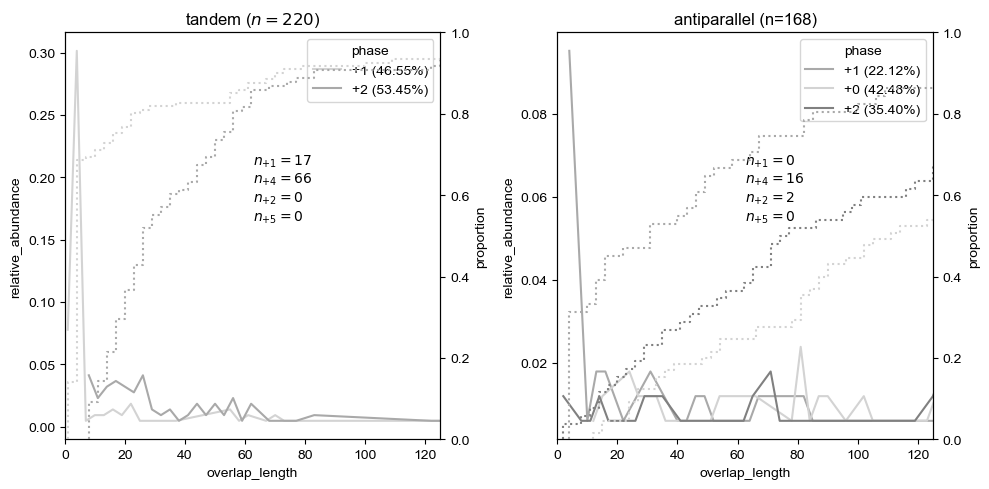

In [ ]:
# TODO: Should look at the query coverages for the overlaps with non-CDS features. 

figure_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
figure_df['phase'] = figure_df.overlap_length % 3
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)

titles = {True:f'tandem ($n={figure_df.same_strand.sum()}$)', False:f'antiparallel ($n={(~figure_df.same_strand).sum()}$)'}

for ax, same_strand in zip(axes, [True, False]):
    ax_df = figure_df[figure_df.same_strand == same_strand].copy()
    ax_df = ax_df[ax_df.index != 'NZ_FAOO01000018.1_5'] # One of the tandem overlaps is +0 because the top hit is partial, and the query has a ton of X's in the middle.
    phase_counts = ax_df.phase.value_counts().to_dict()
    ax_df['phase'] = [f'+{phase} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]

    palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
    ax_ = sns.ecdfplot(ax_df, x='overlap_length', hue='phase', palette=palette, ls=':', ax=ax.twinx(), legend=False)
    ax_.set_ylabel('proportion')

    ax_df = ax_df.overlap_length.value_counts().reset_index()
    ax_df['phase'] = ax_df.overlap_length % 3
    phase_counts = ax_df.phase.value_counts().to_dict()
    ax_df['phase'] = [f'+{phase} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]
    ax_df['relative_abundance'] = ax_df['count'] / ax_df['count'].sum()
    
    palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
    sns.lineplot(ax_df, x='overlap_length', y='relative_abundance', hue='phase', palette=palette, ax=ax)

    text = ''
    for overlap_length in [1, 4, 2, 5]:
        n = ax_df[ax_df.overlap_length == overlap_length]['count']
        n = 0 if len(n) == 0 else n.iloc[0]
        text += '$n_{+' + str(overlap_length) + '} = ' + str(n) + '$\n'
    ax.text(0.5, 0.5, text, transform=ax.transAxes)
    ax.set_title(titles[same_strand])

    ax.set_xlim(xmin=0, xmax=125)

fig.tight_layout()



In [134]:
is_partial_at_c_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == -1) or ((partial[-1] == '1') and (strand == 1))
is_partial_at_n_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == 1) or ((partial[-1] == '1') and (strand == -1))

is_query_partial_at_c_terminus = lambda row : is_partial_at_c_terminus(row.query_strand, row.query_partial)
is_top_hit_partial_at_n_terminus = lambda row : ((row.top_hit_partial == '01') and (row.top_hit_strand == 1)) or ((row.top_hit_partial == '10') and (row.top_hit_strand == -1))
is_top_hit_cds = lambda row : (row.top_hit_feature == 'CDS') and not row.top_hit_pseudo

# Overlaps greater than 60 bp are almost certainly spurious. However, the proteins could still be in-frame with a genuine ORF, and the 
# overlap may be the result of a boundary error. Sequences can be extended at the N-terminus due to erroneous start-codon selection, or extended 
# at the C-terminus due to a frameshift mutation. N-terminal extensions are the most common cause of overlap, and also the simplest to detect, 
# so will probably limit analysis to these. 

# Conflicts that are potentially the result of N-terminal extension include:
# (1) Divergent overlaps where one or both sequence coordinates are the product of ab initio prediction. 
# (2) Tandem overlaps where the downstream sequence coordinates are the product of ab initio prediction. 
# (2) Nested overlaps where one or both sequence coordinates are the product of ab initio prediction. 

query_start_in_top_hit = lambda df : (df.query_start <= df.top_hit_stop) & (df.query_start >= df.top_hit_start)
query_stop_in_top_hit = lambda df : (df.query_stop <= df.top_hit_stop) & (df.query_stop >= df.top_hit_start)
top_hit_start_in_query = lambda df : (df.top_hit_start <= df.query_stop) & (df.top_hit_start >= df.query_start)
top_hit_stop_in_query = lambda df : (df.top_hit_stop <= df.query_stop) & (df.top_hit_stop >= df.query_start)

is_conflict_at_query_n_terminus = lambda df : (df.query_strand == 1) & query_start_in_top_hit(df) | ((df.query_strand == -1) & query_stop_in_top_hit(df))
is_conflict_at_top_hit_n_terminus = lambda df : ((df.top_hit_strand == 1) & top_hit_start_in_query(df) | ((df.top_hit_strand == -1) & top_hit_stop_in_query(df)))

def get_alternate_coordinates(nt_seq:str=None, start:int=None, stop:int=None, strand:int=None, codon_start:int=1, partial:str=None):
    
    if nt_seq == 'none':
        return np.array([start]), np.array([stop])
    nt_seq = nt_seq[int(codon_start) - 1:]
    
    start_codons = ['AUG', 'GUG', 'UUG']
    codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq) + 1, 3)])
    start_codon_idxs = np.where(np.isin(codons, start_codons))[0]
    # WP_259095463.1 does not seem to have a start codon?
    if len(start_codon_idxs) == 0:
        return np.array([start]), np.array([stop])
    
    assert (len(nt_seq) % 3 == 0) or is_partial_at_c_terminus(strand, partial), f'get_alternate_coordinates: Nucleotide sequence length should be divisible by three, got {len(nt_seq)}.'
    assert len(''.join(codons)) == len(nt_seq), 'get_alternate_coordinates: Joined codons should have the same length as the original nucleotide sequence.'
    # assert len(start_codon_idxs) >= 1 or is_partial_at_n_terminus(strand, partial), f'get_alternate_starts: Should be at least one start codon. {nt_seq}'

    start_codon_idxs = 3 * start_codon_idxs

    if strand == 1:
        starts = start + start_codon_idxs
        stops = np.array([stop] * len(starts))
    elif strand == -1:
        stops = stop - start_codon_idxs 
        starts = np.array([start] * len(stops))
    return starts, stops 

has_overlap = lambda row : not ((row.query_stop < row.top_hit_start) or (row.query_start > row.top_hit_stop))
get_overlap_length = lambda row : 0 if not has_overlap(row) else min(row.query_stop, row.top_hit_stop) - max(row.query_start, row.top_hit_start)
get_overlap_type = lambda row : reference.get_overlap_type(query_start=row.query_start, query_stop=row.query_stop, subject_start=row.top_hit_start, subject_stop=row.top_hit_stop, query_strand=row.query_strand, subject_strand=row.top_hit_strand)

is_top_hit_coordinate_adjustable = lambda row : is_top_hit_cds(row) and not (('programmed frameshift' in row.top_hit_note) | (row.top_hit_evidence_source == 'similar to AA sequence'))

def get_configurations(row):
    query_starts, query_stops = get_alternate_coordinates(start=row.query_start, stop=row.query_stop, strand=row.query_strand, nt_seq=row.query_nt_seq, partial=row.query_partial)
    if is_top_hit_coordinate_adjustable(row):
        top_hit_starts, top_hit_stops = get_alternate_coordinates(start=row.top_hit_start, stop=row.top_hit_stop, strand=row.top_hit_strand, nt_seq=row.top_hit_nt_seq, partial=row.top_hit_partial, codon_start=row.top_hit_codon_start)
    else:
        top_hit_starts, top_hit_stops = ([row.top_hit_start], [row.top_hit_stop])

    config_df = list()
    for query_start, query_stop in zip(query_starts, query_stops):
        for top_hit_start, top_hit_stop in zip(top_hit_starts, top_hit_stops):
            config_info = {'query_start':query_start, 'top_hit_start':top_hit_start, 'query_stop':query_stop, 'top_hit_stop':top_hit_stop}
            config_df.append(config_info)
    config_df = pd.DataFrame(config_df)
    config_df['query_length'] = config_df.query_stop - config_df.query_start + 1
    config_df['top_hit_length'] = config_df.top_hit_stop - config_df.top_hit_start + 1
    config_df['original_top_hit_length'] = row.top_hit_stop - row.top_hit_start + 1
    config_df['original_query_length'] = row.query_stop - row.query_start + 1
    config_df['top_hit_strand'] = row.top_hit_strand 
    config_df['query_strand'] = row.query_strand
    config_df['top_hit_feature'] = row.top_hit_feature
    config_df['top_hit_pseudo'] = row.top_hit_pseudo
    config_df['original_overlap_type'] = row.overlap_type 
    config_df['overlap_length'] = config_df.apply(get_overlap_length, axis=1)
    config_df['overlap_type'] = config_df.apply(get_overlap_type, axis=1).values # .values # Should re-assign overlap type following coordinate modifications.
    return config_df

is_valid_overlap = lambda df : ((df.overlap_type == 'tandem') & (df.overlap_length < 10)) | (df.overlap_type == 'none')

def get_configuration_info(row, min_length:int=30):
    # How to pick the best configuration? Perhaps the one with the smallest overlap length, as well as the one where the sum of the query and top hit lengths is the largest.
    # Actually makes more sense to allow larger truncations of the longer sequences, so perhaps try to preserve the largest mean fraction. 
    config_df = get_configurations(row)
    config_df = config_df[(config_df.query_length >= min_length) & (config_df.query_length >= min_length)].copy()
    config_df = config_df[is_valid_overlap(config_df)]
    if len(config_df) == 0:
        return None 
    
    best_overlap_length = config_df.overlap_length.min()
    config_df = config_df[config_df.overlap_length == best_overlap_length].copy()
    config_df['score'] = (config_df.query_length / config_df.original_query_length + config_df.top_hit_length / config_df.original_top_hit_length) / 2
    # config_df = config_df.sort_values(by='query_length', key=lambda col : config_df.top_hit_length + config_df.query_length, ascending=False)
    config_df = config_df.sort_values(by='score', ascending=False) #, key=lambda col : config_df.top_hit_length + config_df.query_length, ascending=False)
    
    config_info = config_df.iloc[0].to_dict()
    config_info.update({'id':row.Index})
    config_info.update({'original_overlap_length':row.overlap_length})
    return config_info


is_conflict_from_n_terminal_extension = lambda df : df.conflict & (is_conflict_at_query_n_terminus(df) | is_conflict_at_top_hit_n_terminus(df)) # & ~(df.top_hit_evidence_source == 'similar to AA sequence')))

print('Num. possible conflicts due to N-terminal extension:', is_conflict_from_n_terminal_extension(dataset_df).sum())
print('Num. invalid conflicts due to N-terminal extension:', (is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)).sum())

repairable_conflict_df = dataset_df[is_conflict_from_n_terminal_extension(dataset_df)] # & ~is_valid_overlap(dataset_df)]
repaired_conflict_df = list()
for row in repairable_conflict_df.itertuples():
    config_info = get_configuration_info(row)
    if config_info is None:
        continue
    repaired_conflict_df.append(config_info)
repaired_conflict_df = pd.DataFrame(repaired_conflict_df)

Num. possible conflicts due to N-terminal extension: 446
Num. invalid conflicts due to N-terminal extension: 353


In [135]:

print('Num. repaired conflicts:', len(repaired_conflict_df))
print('Num. repaired conflicts with non-coding elements:', is_non_coding_conflict(repaired_conflict_df.assign(conflict=True)).sum())
print('Num. repaired conflicts with CDS:', is_cds_conflict(repaired_conflict_df.assign(conflict=True)).sum())


Num. repaired conflicts: 331
Num. repaired conflicts with non-coding elements: 15
Num. repaired conflicts with CDS: 311


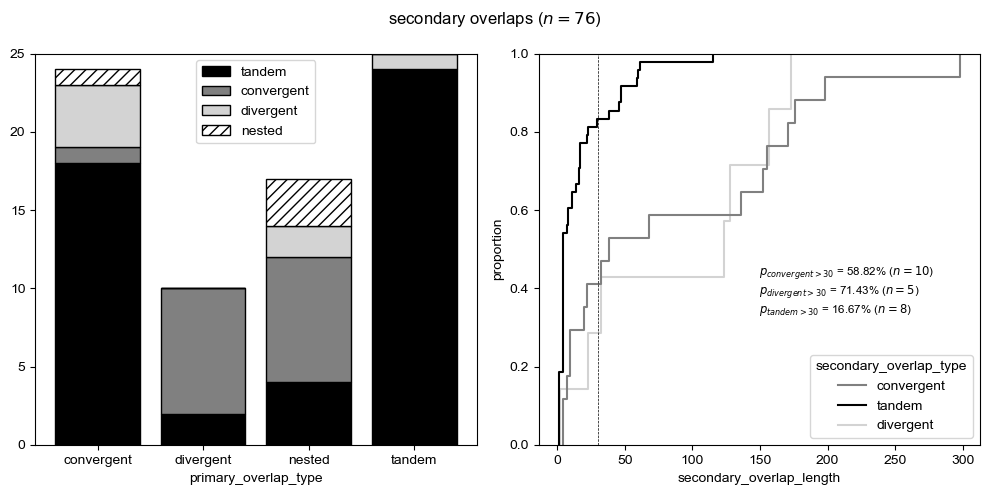

In [ ]:
# Maybe worth characterizing the secondary overlaps too... 
def si_figure_2(dataset_df:pd.DataFrame, all_hits_df:pd.DataFrame):

    totals = dataset_df[is_cds_conflict(dataset_df)].overlap_type.value_counts()
    ids = dataset_df[(dataset_df.n_hits > 1) & is_cds_conflict(dataset_df)].index.values

    fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
    overlap_types = ['divergent', 'convergent', 'tandem', 'nested']

    positions = np.arange(len(overlap_types))

    figure_df = list()
    for id_ in ids:
        row = {'id':id_}
        df = all_hits_df[all_hits_df.query_id == id_].sort_values('overlap_length', ascending=False)
        row['primary_overlap_type'] = df.iloc[0].overlap_type 
        row['secondary_overlap_type'] = df.iloc[1].overlap_type 
        row['secondary_overlap_length'] = df.iloc[1].overlap_length 
        row['secondary_overlap_uncertain'] = (df.iloc[0].subject_evidence_type == 'ab initio prediction') and (df.iloc[0].subject_product == 'hypothetical protein')
        figure_df.append(row)
    figure_df = pd.DataFrame(figure_df).set_index('id')

    ax_a_df = figure_df.groupby('primary_overlap_type').secondary_overlap_type.value_counts()
    ax_a_df = ax_a_df.reset_index().pivot(columns='primary_overlap_type', index='secondary_overlap_type', values='count').fillna(0)
    ax_a_df = ax_a_df.loc[['tandem', 'convergent', 'divergent', 'nested']]
    
    bottom = np.zeros(len(ax_a_df))
    positions = np.arange(len(ax_a_df))
    palette = {'tandem':'black', 'convergent':'gray', 'divergent':'lightgray', 'nested':'white'}
    for overlap_type in ax_a_df.index:
        heights = ax_a_df.loc[overlap_type].values
        ax_a.bar(positions, heights, bottom=bottom, color=palette[overlap_type], edgecolor='black', label=overlap_type, hatch='///' if (overlap_type == 'nested') else None)
        bottom += heights
    ax_a.set_xticks(positions, labels=ax_a_df.columns)
    ax_a.legend()
    ax_a.set_xlabel('primary_overlap_type')

    ax_b_df = figure_df[figure_df.secondary_overlap_type != 'nested'].copy()
    # sns.ecdfplot(data=ax_b_df[ax_b_df.secondary_overlap_uncertain], x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, ls=':')
    sns.ecdfplot(data=ax_b_df, x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, palette=palette)
    ax_b.set_ylabel('proportion')

    overlap_length, text = 30, ''
    for overlap_type, df in ax_b_df.groupby('secondary_overlap_type'):
        n = (df.secondary_overlap_length > overlap_length).sum()
        text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    fig.suptitle(f'secondary overlaps ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

si_figure_2(dataset_df, all_hits_df)

[(np.int64(3010199), 3010501)]


(np.int64(302), np.int64(273), np.int64(303))

In [ ]:
threshold = 0.95 

results_df = pd.read_csv('../data/results/rare_taxa_predict.csv', index_col=0)
results_df.columns = [col.replace('_v2', '') for col in results_df.columns]
results_df = results_df.merge(dataset_df, left_index=True, right_index=True, how='inner')
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)


FileNotFoundError: [Errno 2] No such file or directory: '../data/results/rare_taxa_predict.csv'

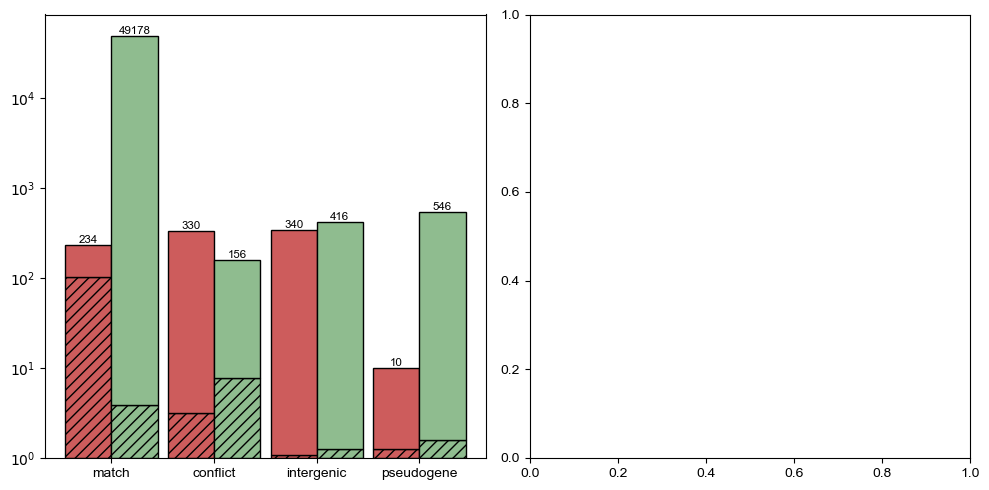

In [ ]:
def figure_2(results_df:pd.DataFrame):

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    figure_df = results_df.copy()
    figure_df['category'] = np.select([results_df.match, results_df.pseudogene, results_df.intergenic, results_df.conflict], ['match', 'pseudogene', 'intergenic', 'conflict'], default='none')
    categories = ['match', 'conflict', 'intergenic', 'pseudogene']
    figure_df['category'] = pd.Categorical(figure_df.category, categories, ordered=True)

    width = 0.45
    offsets = {0: -width/2, 1:width/2}
    palette = {0:'indianred', 1:'darkseagreen'}

    for model_label, df in figure_df.groupby('model_label'):
        ax_df = pd.DataFrame(index=categories)
        ax_df['total'] = df.category.value_counts()
        ax_df['log_total'] = np.log10(ax_df['total'])
        ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
        ax_df['unsupported'] = ax_df['log_total'] * ax_df['fraction']
        ax_df['confirmed'] = ax_df['log_total'] * (1 - ax_df['fraction'])

        positions = np.arange(df.category.nunique())
        ax_a.bar(positions + offsets[model_label], ax_df.unsupported, color=palette[model_label], edgecolor='black', hatch='///', width=width)
        ax_a.bar(positions + offsets[model_label], ax_df.confirmed, bottom=ax_df.unsupported, color=palette[model_label], edgecolor='black', width=width)

        for x, total, log_total in zip(positions + offsets[model_label], ax_df.total, ax_df.log_total):
            text = f'{100 * total / ax_df.total.sum():.2f}%'
            text = total
            ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

    ax_a.set_xticks(positions, labels=ax_df.index)
    ax_a.set_yticks(np.arange(5), labels=[f'$10^{i}$' for i in range(5)])


    fig.tight_layout()
    plt.show()

figure_2(results_df)

# I think should probably combine these bar plots into a single chart. Although there are so many more real than spurious sequences, this might look a bit weird. 

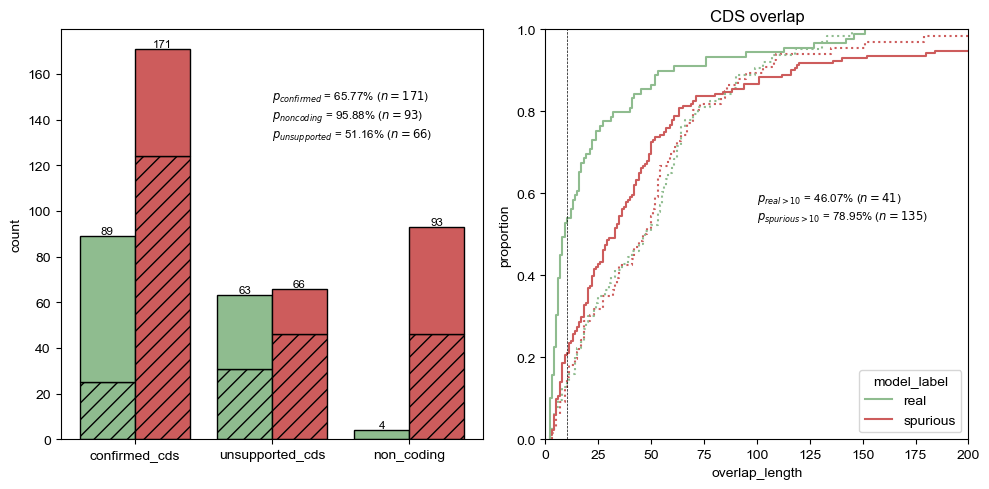

In [ ]:
# TODO: Compute and report Mann-Whitney test statistics for the ECDF curve differences. 
# TODO: Should I mention the fact that overlap length is confounded by overlap orientation?
# TODO: Statistical test showing differences in the antisense vs. sense composition of spurious- and real-labeled sequences. 
# "Because antisense conflicts are generally larger than sense conflicts (SI Figure 3.2.2), it is unclear if overlap length is itself significant, 
# or if the observed difference is a byproduct of model sensitivity to antisense overlap."

def si_figure_3(results_df:pd.DataFrame):
    '''
    (A) A summary of model predictions on conflicting sequences; the fraction of antisense conflicts in each category is indicated by the hatched fill. 
    Spurious-labeled sequences conflicting with supported CDS are significantly more likely to overlap on the antisense strand (p < 1e-11) than their real-labeled counterparts.
    This effect is far less pronounced for sequences conflicting with unsupported CDS (p > 1e-2).
    
    (B) ECDF curves of the overlap lengths for conflicts with supported (solid lines) and unsupported (dashed lines) CDS; p_spurious and p_real 
    are the percentages of conflicts with supported CDS which exceed 10 amino acids in length. Spurious-labeled sequences conflicting with supported CDS have substantially larger
    overlaps than their real-labeled counterparts. Interestingly, there is no significant difference in the ECDF curves of spurious- and real-classified sequences in conflict with
    unsupported CDS. The results presented in (A) and (B) suggest that the model is not sensitive to conflict with unsupported CDS.'''

    figure_df = results_df[results_df.conflict][['top_hit_feature', 'same_strand', 'model_label', 'top_hit_unsupported', 'overlap_length', 'antifam_hit', 'query_overlap_fraction']].copy()
    figure_df['conflict_with_cds'] = figure_df.top_hit_feature == 'CDS'
    figure_df['conflict_with_unsupported_cds'] = (figure_df.top_hit_feature == 'CDS') & (figure_df.top_hit_unsupported)
    figure_df['conflict_with_confirmed_cds'] = (figure_df.top_hit_feature == 'CDS') & (~figure_df.top_hit_unsupported)
    figure_df['conflict_with_non_coding'] = ~figure_df.conflict_with_cds

    fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

    width = 0.4
    offsets = {'real': -width/2, 'spurious':width/2}

    ax_a_df = figure_df.copy()
    categories = ['confirmed_cds', 'unsupported_cds', 'non_coding']
    conditions = [ax_a_df.conflict_with_confirmed_cds, ax_a_df.conflict_with_unsupported_cds, ax_a_df.conflict_with_non_coding]
    ax_a_df['category'] = np.select(conditions, categories, default='none')
    ax_a_df['model_label'] = np.where(ax_a_df.model_label == 1, 'real', 'spurious')

    palette = {'real':'darkseagreen', 'spurious':'indianred'}
    for model_label, df in ax_a_df.groupby('model_label'):
        ax_df = pd.DataFrame(index=categories)
        ax_df['total'] = df.category.value_counts()
        ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : (df.same_strand).sum() / len(df), include_groups=False)
        ax_df['same_strand'] = ax_df['total'] * ax_df['fraction']
        ax_df['opposite_strand'] = ax_df['total'] * (1 - ax_df['fraction'])
        positions = np.arange(ax_a_df.category.nunique())
        ax_a.bar(positions + offsets[model_label], ax_df.opposite_strand,color=palette[model_label], edgecolor='black', hatch='//', width=width)
        ax_a.bar(positions + offsets[model_label], ax_df.same_strand, bottom=ax_df.opposite_strand, color=palette[model_label], edgecolor='black', width=width)

        for x, total in zip(positions + offsets[model_label], ax_df.total):
            text = total
            ax_a.text(x, total, text, ha='center', fontsize='small', va='bottom')

    ax_a.set_xticks(positions, labels=ax_df.index)
    ax_a.set_ylabel('count')

    text = ''
    for category, df in ax_a_df.groupby('category'):
        n = (df.model_label == 'spurious').sum()
        category = category.replace('_', ' ').replace('cds', '')
        text += '$p_{' + category + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    ax_a.text(0.5, 0.7, text, transform=ax_a.transAxes, fontsize='small')


    ax_b_df = figure_df[figure_df.conflict_with_cds].copy()
    ax_b_df['overlap_length'] = ax_b_df.overlap_length // 3 # Convert to units of amino acids. 
    ax_b_df['model_label'] = np.where(ax_b_df.model_label == 0, 'spurious', 'real')
    palette = {'real':'darkseagreen', 'spurious':'indianred'}
    sns.ecdfplot(ax=ax_b, data=ax_b_df[ax_b_df.top_hit_unsupported], hue='model_label', x='overlap_length', palette=palette, ls=':')
    sns.ecdfplot(ax=ax_b, data=ax_b_df[~ax_b_df.top_hit_unsupported], hue='model_label', x='overlap_length', palette=palette)

    text = ''
    overlap_length = 10
    for model_label, df in ax_b_df[~ax_b_df.top_hit_unsupported].groupby('model_label'):
        n_overlap_greater_than = (df.overlap_length > overlap_length).sum()
        text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n_overlap_greater_than, len(df))} ($n={n_overlap_greater_than}$)\n'
    ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    ax_b.set_xlim(xmax=200, xmin=0)
    ax_b.set_title('CDS overlap')
    ax_b.set_ylabel('proportion')

    fig.tight_layout()
    plt.show()

# Could add some annotation to panel A... What summary statistics might be helpful?
si_figure_3(results_df)

In [ ]:
get_supported_cds_conflicts = lambda df : df[(~df.top_hit_unsupported) & (df.top_hit_feature == 'CDS') & (df.conflict)].copy()
get_unsupported_cds_conflicts = lambda df : df[(df.top_hit_unsupported) & (df.top_hit_feature == 'CDS') & (df.conflict)].copy()

n_spurious = (get_supported_cds_conflicts(results_df).model_label == 0).sum()
n_real = (get_supported_cds_conflicts(results_df).model_label == 1).sum()

f_observed_supported_cds = get_supported_cds_conflicts(results_df).value_counts(['model_label', 'same_strand']).loc[[1, 0]].values
f_expected_supported_cds = [0.5 * n_real, 0.5 * n_real, 0.5 * n_spurious, 0.5 * n_spurious]

n_spurious = (get_unsupported_cds_conflicts(results_df).model_label == 0).sum()
n_real = (get_unsupported_cds_conflicts(results_df).model_label == 1).sum()

f_observed_unsupported_cds = get_unsupported_cds_conflicts(results_df).value_counts(['model_label', 'same_strand']).loc[[1, 0]].values
f_expected_unsupported_cds = [0.5 * n_real, 0.5 * n_real, 0.5 * n_spurious, 0.5 * n_spurious]

print('Chi-squared test for sense versus antisense conflict with unsupported CDS:', chisquare(f_observed_unsupported_cds, f_expected_unsupported_cds).pvalue)
print('Chi-squared test for sense versus antisense conflict with supported CDS:', chisquare(f_observed_supported_cds, f_expected_supported_cds).pvalue)

Chi-squared test for sense versus antisense conflict with unsupported CDS: 0.01649342370904482
Chi-squared test for sense versus antisense conflict with supported CDS: 3.3654563318712514e-11


In [ ]:
real_labeled_non_coding_conflict_ids = results_df[(results_df.top_hit_feature != 'CDS') & (results_df.model_label == 1) & results_df.conflict].index
for row in results_df.loc[real_labeled_non_coding_conflict_ids].itertuples():
    print('Feature:', row.top_hit_feature)
    print('Overlap length (bp):', row.overlap_length, '(same strand)' if row.same_strand else '(opposite strand)')
    print('Model confidence:', f'{100 * row.model_output_1:.2f}%', end='\n\n')


Feature: rRNA
Overlap length (bp): 117 (same strand)
Model confidence: 10.26%

Feature: rRNA
Overlap length (bp): 363 (same strand)
Model confidence: 100.00%

Feature: regulatory
Overlap length (bp): 11 (same strand)
Model confidence: 98.35%

Feature: ncRNA
Overlap length (bp): 135 (same strand)
Model confidence: 5.27%



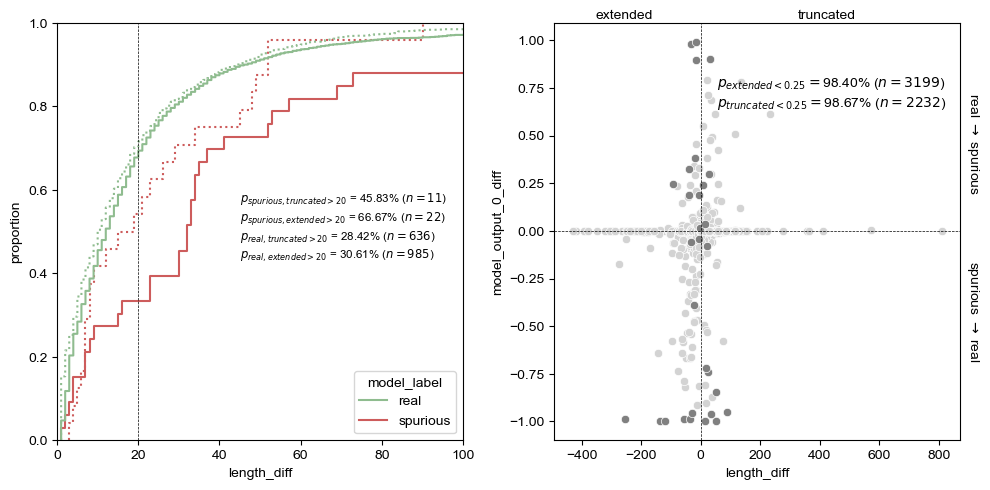

In [ ]:
def si_figure_4(results_df:pd.DataFrame):
    '''(A) (B).'''

    figure_df = results_df[results_df.match].copy()
    figure_df = results_df[results_df.extended | results_df.truncated].copy()
    figure_df['length_diff'] = np.abs(results_df.top_hit_seq.apply(len) - results_df.seq.apply(len))
    figure_df['model_label'] = np.where(figure_df.model_label == 0, 'spurious', 'real')
    figure_df['overlap_length'] = figure_df.overlap_length // 3

    # If model_output_0_diff is positive, then the reference sequence is more likely to be spurious. 
    # If model_output_0_diff is negative, then the reference sequence is more likely to be real. 
    reference_df = pd.read_csv('../data/results/rare_taxa_matches_reference_predict.csv', index_col=0)
    reference_df.columns = [col.replace('model_v2', 'model') for col in reference_df.columns]
    figure_df['top_hit_model_output_0'] = reference_df.model_output_0
    figure_df['top_hit_model_label'] = np.where(figure_df.top_hit_model_output_0 > 0.95, 'spurious', 'real')
    figure_df['model_output_0_diff'] = figure_df.top_hit_model_output_0 - figure_df.model_output_0

    mask = figure_df.model_label != figure_df.top_hit_model_label
    palette = {'real':'darkseagreen', 'spurious':'indianred'}

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    sns.ecdfplot(figure_df[figure_df.truncated], x='length_diff', hue='model_label', ax=ax_a, ls=':', palette=palette)
    sns.ecdfplot(figure_df[figure_df.extended], x='length_diff', hue='model_label', ax=ax_a, palette=palette)

    # sns.ecdfplot(figure_df[figure_df.truncated & (figure_df.model_label == 'spurious') & ~mask], x='length_diff', ax=ax_a, ls=':', color='lightgray') #, palette=palette)
    # sns.ecdfplot(figure_df[figure_df.extended & (figure_df.model_label == 'spurious') & ~mask], x='length_diff', ax=ax_a, color='lightgray') #, palette=palette)

    ax_a.set_xlim(xmax=100, xmin=0)

    masks = dict()
    masks['spurious,truncated'] = (figure_df.truncated) & (figure_df.model_label == 'spurious')
    masks['spurious,extended'] = (figure_df.extended) & (figure_df.model_label == 'spurious')
    masks['real,truncated'] = (figure_df.truncated) & (figure_df.model_label == 'real')
    masks['real,extended'] = (figure_df.extended) & (figure_df.model_label == 'real')
    text = ''
    for label, mask in masks.items():
        n = (mask & (figure_df.length_diff > 20)).sum()
        text += '$p_{' + label + ' > 20}$' + f' = {get_percent(n, mask.sum())} ($n={n}$)\n'
    ax_a.text(0.45, 0.4, text, transform=ax_a.transAxes, fontsize='small')
    ax_a.axvline(x=20, ls='--', color='black', lw=0.5)
    ax_a.set_ylabel('proportion')

    figure_df['length_diff'] = figure_df.top_hit_length - figure_df.length
    sns.scatterplot(figure_df, x='length_diff', y='model_output_0_diff', ax=ax_b, color='lightgray')
    sns.scatterplot(figure_df[figure_df.top_hit_model_label != figure_df.model_label], x='length_diff', y='model_output_0_diff', ax=ax_b, color='gray')

    ax_b.text(0.1, 1.01, 'extended', transform=ax_b.transAxes)
    ax_b.text(0.6, 1.01, f'truncated', transform=ax_b.transAxes)
    ax_b.text(1.01, 0.2, r'spurious $\rightarrow$ real', transform=ax_b.transAxes, rotation=270)
    ax_b.text(1.01, 0.6, r'real $\rightarrow$ spurious', transform=ax_b.transAxes, rotation=270)

    model_output_0_diff = 0.25
    n_extended_less_than_model_output_0_diff = (np.abs(figure_df[figure_df.extended].model_output_0_diff) < model_output_0_diff).sum()
    n_truncated_less_than_model_output_0_diff = (np.abs(figure_df[figure_df.truncated].model_output_0_diff) < model_output_0_diff).sum()
    
    text = '$p_{extended<0.25} =$' + f'{get_percent(n_extended_less_than_model_output_0_diff, figure_df.extended.sum())} ($n={n_extended_less_than_model_output_0_diff}$)\n'
    text += '$p_{truncated<0.25} =$' + f'{get_percent(n_truncated_less_than_model_output_0_diff, figure_df.truncated.sum())} ($n={n_truncated_less_than_model_output_0_diff}$)'
    ax_b.text(0.4, 0.8, text, transform=ax_b.transAxes)

    ax_b.axhline(y=0, ls='--', color='black', lw=0.5)
    ax_b.axvline(x=0, ls='--', color='black', lw=0.5)
    
    fig.tight_layout()
    plt.show()

si_figure_4(results_df)


(0.0, 400.0)

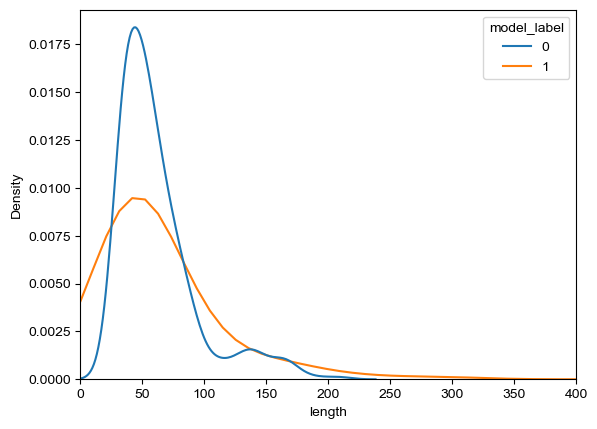

In [ ]:
assert np.all(results_df.length == results_df.seq.apply(len))
fig, ax = plt.subplots()
sns.kdeplot(results_df[results_df.intergenic], x='length', hue='model_label', ax=ax, common_norm=False)
ax.set_xlim(xmax=400, xmin=0)

In [ ]:
ids = dataset_df[dataset_df.intergenic].index 
df = interpro_df.loc[np.intersect1d(ids, interpro_df.index)]
df = df[~df.interpro_e_value.isnull()]
df.index.nunique()

37

In [ ]:
def figure(matches_df:pd.DataFrame, use_reference:bool=False):

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    ax_df = matches_df.copy()
    if use_reference:
        for col in ['model_label', 'length', 'seq']:
            ax_df[col] = ax_df[f'top_hit_{col}']
    
    n_spurious = (ax_df.model_label == 0).sum()
    n_spurious_hypothetical = ((ax_df.model_label == 0) & (ax_df.top_hit_product == 'hypothetical protein')).sum()
    n_spurious_ab_initio = ((ax_df.model_label == 0) & (ax_df.top_hit_evidence_source.str.contains('GeneMark'))).sum()
    n_real = (ax_df.model_label == 1).sum()
    spurious_label, real_label = f'spurious (n={n_spurious})', f'real (n={n_real})'

    print(f'figure: {n_spurious_hypothetical} of the proteins classified as spurious are unannotated.')
    print(f'figure: {n_spurious_ab_initio} of the proteins classified as spurious are ab initio predictions.')
    
    ax_df = ax_df[ax_df.top_hit_evidence_source != 'INFERNAL'].copy() # Not enough annotated with INFERNAL to look good on the plot. 
    ax_df['model_label'] = ax_df.model_label.replace({0:spurious_label, 1:real_label})
    palette = {real_label:'darkseagreen', spurious_label:'indianred'}

    sns.ecdfplot(data=ax_df, x='length', hue='model_label', ax=ax_a, palette=palette)

    n_spurious_smorfs = ((ax_df.length < 100) & (ax_df.model_label == spurious_label)).sum()
    n_spurious = (ax_df.model_label == spurious_label).sum()

    text = '$p_{spurious<100}=$' + f'{get_percent(n_spurious_smorfs, n_spurious)}'
    ax_a.text(0.5, 0.5, text, transform=ax_a.transAxes)
    ax_a.axvline(x=100, ls='--', lw=0.5, color='black')
    ax_a.set_ylabel('proportion')

    sns.histplot(data=ax_df, x='top_hit_evidence_source', hue='model_label', ax=ax_b, multiple='dodge', stat='probability', common_norm=False, shrink=0.8, palette=palette)
    ax_b.set_ylabel('probability')
    plt.show()


In [ ]:
# I selected a minimum overlap length of 30, as it seems as though around 10 amino acids might be sufficient for a BLAST hit
# if the Prodigal prediction is translated in the same frame as the underlying gene.    


pseudogenes_df = results_df[results_df.pseudogene].copy()
FASTAFile(df=pseudogenes_df).write('../data/results/rare_taxa_pseudogenes.faa')

print('Number of pseudogenes predicted to be real:', (pseudogenes_df.model_label == 1).sum())
print('Number of pseudogenes predicted to be spurious:', (pseudogenes_df.model_label == 0).sum())
print('Number of pseudogenes predicted to be real (> 95% confidence):', (pseudogenes_df.model_output_1 > 0.95).sum())
print('Number of pseudogenes predicted to be spurious (> 95% confidence):', (pseudogenes_df.model_output_0 > 0.95).sum())


Number of pseudogenes predicted to be real: 546
Number of pseudogenes predicted to be spurious: 10
Number of pseudogenes predicted to be real (> 95% confidence): 519
Number of pseudogenes predicted to be spurious (> 95% confidence): 10


In [ ]:
# How many of the pseudogene hits list the reference sequence used to detect the pseudogene?
print(pseudogenes_df.top_hit_evidence_details.str.contains('WP_').sum(), 'pseudogenes with a RefSeq reference protein.')
pseudogene_to_refseq_reference_map = pseudogenes_df[pseudogenes_df.top_hit_evidence_details.str.contains('WP_')].top_hit_evidence_details.to_dict()

if not os.path.exists('../data/results/rare_taxa_pseudogenes_reference.faa'):
    ncbi = NCBI()
    pseudogenes_reference_df = ncbi.get_proteins(set(pseudogene_to_refseq_reference_map.values()), path=None) # , path='../data/results/rare_taxa_pseudogenes_reference.faa')
    pseudogenes_reference_df = pseudogenes_reference_df[~pseudogenes_reference_df.index.duplicated()].copy()
    ncbi.cleanup()

    swissprot_df = pd.read_csv('../data/dataset/swissprot_bacteria.csv', index_col=0)
    swissprot_df = swissprot_df[['seq', 'product']].rename(columns={'product':'description'})
    swissprot_df = swissprot_df[~swissprot_df.index.duplicated()].copy()
    pseudogenes_reference_df = pd.concat([pseudogenes_reference_df, swissprot_df], axis=0)
    
    FASTAFile(df=pseudogenes_reference_df).write('../data/results/rare_taxa_pseudogenes_reference.faa')

else:
    pseudogenes_reference_df = FASTAFile(path='../data/results/rare_taxa_pseudogenes_reference.faa').to_df(prodigal_output=False)
    pseudogenes_reference_df = pseudogenes_reference_df[~pseudogenes_reference_df.index.duplicated()].copy()

364 pseudogenes with a RefSeq reference protein.


In [ ]:
mmseqs = tools.MMSeqs()
pseudogenes_align_df = mmseqs.align(pseudogenes_df, subject_df=pseudogenes_reference_df, query_name='rare_taxa_pseudogenes', subject_name='rare_taxa_pseudogenes_reference', output_dir='../data/results/')

# Filter the alignments to include only those between a translated pseudogene and the protein used to identify the pseudogene in the PGAP-annotated assembly.
is_alignment_to_refseq_reference = lambda row : (pseudogene_to_refseq_reference_map[row.query_id] == row.subject_id) if (row.query_id in pseudogene_to_refseq_reference_map.keys()) else False
is_alignment_to_swissprot = lambda row : not row.subject_id.startswith('WP_')

pseudogenes_align_df = pseudogenes_align_df[pseudogenes_align_df.query_id.isin(pseudogenes_df.index)].copy()
pseudogenes_align_df['alignment_to_refseq_reference'] = pseudogenes_align_df.apply(is_alignment_to_refseq_reference, axis=1)
pseudogenes_align_df['alignment_to_swissprot'] = pseudogenes_align_df.apply(is_alignment_to_swissprot, axis=1)
n_alignments_to_wrong_refseq_reference = (~pseudogenes_align_df.alignment_to_refseq_reference & ~pseudogenes_align_df.alignment_to_swissprot).sum()
print(n_alignments_to_wrong_refseq_reference, 'alignments to a RefSeq reference sequence different than the one used to identify the pseudogene.')
pseudogenes_align_df = pseudogenes_align_df[pseudogenes_align_df.alignment_to_refseq_reference | pseudogenes_align_df.alignment_to_swissprot]
pseudogenes_align_df['subject_source'] = ['RefSeq' if subject_id.startswith('WP_') else 'SwissProt' for subject_id in pseudogenes_align_df.subject_id]

pseudogenes_align_df = pseudogenes_align_df.sort_values('bit_score', ascending=False)
pseudogenes_align_df = pseudogenes_align_df.drop_duplicates(subset=['query_id', 'subject_source'])

1235 alignments to a RefSeq reference sequence different than the one used to identify the pseudogene.


In [ ]:
get_significant_alignments = lambda df : df[df.bit_score > 50]

print(pseudogenes_align_df.alignment_to_refseq_reference.sum(), 'of the translated pseudogenes could be aligned with their corresponding reference RefSeq protein.')
print(pseudogenes_align_df.alignment_to_swissprot.sum(), 'of the translated pseudogenes could be aligned to a SwissProt protein.', end='\n\n')

print(get_significant_alignments(pseudogenes_align_df).alignment_to_refseq_reference.sum(), 'of the translated pseudogenes could be aligned with their corresponding reference RefSeq protein with a bit score > 50.')
print(get_significant_alignments(pseudogenes_align_df).alignment_to_swissprot.sum(), 'of the translated pseudogenes could be aligned to a SwissProt protein with a bit score > 50.')

357 of the translated pseudogenes could be aligned with their corresponding reference RefSeq protein.
500 of the translated pseudogenes could be aligned to a SwissProt protein.

346 of the translated pseudogenes could be aligned with their corresponding reference RefSeq protein with a bit score > 50.
344 of the translated pseudogenes could be aligned to a SwissProt protein with a bit score > 50.


In [ ]:
pseudogenes_interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
pseudogenes_interpro_df = pseudogenes_interpro_df[pseudogenes_interpro_df.index.isin(pseudogenes_df.index)].copy() # Obtain annotations for the translated pseudogenes. 
pseudogenes_interpro_df = pseudogenes_interpro_df[~pseudogenes_interpro_df.interpro_analysis.isin(['MobiDBLite', 'Coils'])]
pseudogenes_interpro_df = pseudogenes_interpro_df.sort_values('interpro_e_value')
pseudogenes_interpro_df = pseudogenes_interpro_df[~pseudogenes_interpro_df.index.duplicated(keep='first')]

print(len(pseudogenes_interpro_df), 'of the translated pseudogenes could be annotated by InterProScan.')
print((pseudogenes_interpro_df.interpro_e_value < 1e-5).sum(), 'of the translated pseudogenes have a significant InterProScan annotation.')

468 of the translated pseudogenes could be annotated by InterProScan.
453 of the translated pseudogenes have a significant InterProScan annotation.


In [ ]:
table_df = pd.DataFrame(index=pseudogenes_df.index)
table_df['alignment'] = table_df.index.isin(pseudogenes_align_df.query_id.unique())
table_df['alignment_significant'] = table_df.index.isin(get_significant_alignments(pseudogenes_align_df).query_id.unique())
table_df['interpro_hit'] = table_df.index.isin(pseudogenes_interpro_df.index)
table_df['interpro_hit_significant'] = table_df.index.isin(pseudogenes_interpro_df[pseudogenes_interpro_df.interpro_e_value < 1e-5].index)

# Everything that has a SwissProt alignment also has either a reference alignment or an InterPro annotation.
table_df['has_significant_homology'] = table_df.alignment_significant | table_df.interpro_hit_significant
table_df['has_weak_homology'] = (table_df.alignment | table_df.interpro_hit) & ~table_df.has_significant_homology

pseudogenes_with_no_homology = table_df[~table_df.has_weak_homology & ~table_df.has_significant_homology].index.to_numpy()
pseudogenes_with_significant_homology = table_df[table_df.has_significant_homology].index.to_numpy()
pseudogenes_with_alignment = table_df[table_df.alignment].index.to_numpy() 

pseudogenes_with_significant_alignment = table_df[table_df.alignment].index.to_numpy() 
pseudogenes_with_significant_interpro_hit = table_df[table_df.interpro_hit_significant].index.to_numpy() 

print('Number of translated pseudogenes with significant homology:', table_df.has_significant_homology.sum())
print('Number of translated pseudogenes with weak homology:', table_df.has_weak_homology.sum()) 
print('Number of translated pseudogenes with no homology:', len(pseudogenes_with_no_homology), end='\n\n') 

print('Number of translated pseudogenes with an alignment:', table_df.alignment.sum())
print('Number of translated pseudogenes with an InterProScan annotation and no alignment:', (~table_df.alignment & table_df.interpro_hit).sum())
print('Number of translated pseudogenes with a significant InterProScan annotation and no alignment:', (~table_df.alignment & table_df.interpro_hit_significant).sum())


Number of translated pseudogenes with significant homology: 504
Number of translated pseudogenes with weak homology: 28
Number of translated pseudogenes with no homology: 24

Number of translated pseudogenes with an alignment: 522
Number of translated pseudogenes with an InterProScan annotation and no alignment: 10
Number of translated pseudogenes with a significant InterProScan annotation and no alignment: 8


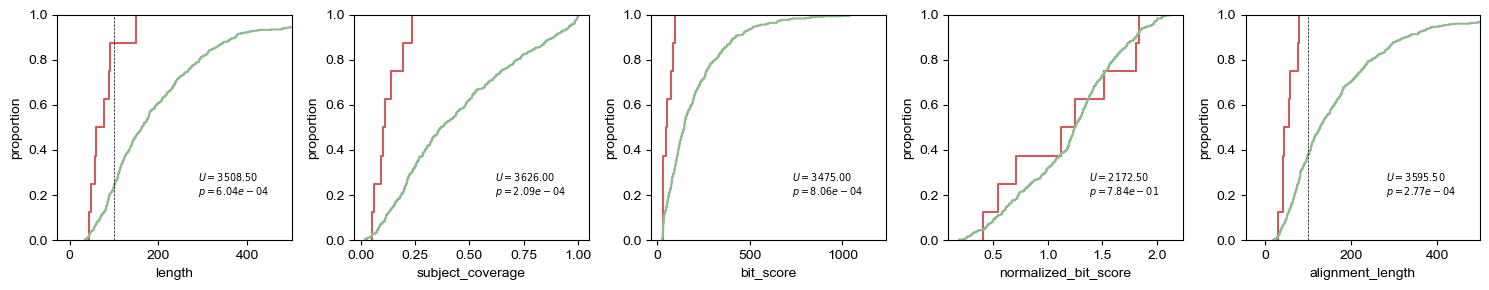

In [ ]:
vars = ['length', 'subject_coverage', 'bit_score', 'normalized_bit_score', 'alignment_length']
fig, axes = plt.subplots(ncols=len(vars), figsize=(3 * len(vars), 3))



ax_df = pseudogenes_align_df.drop_duplicates('query_id').set_index('query_id').copy()
ax_df['model_output_1'] = pseudogenes_df.model_output_1
ax_df['model_label'] = pseudogenes_df.model_label.replace({0:'spurious', 1:'real'})
ax_df['length'] = ax_df.query_seq.apply(len)
ax_df['normalized_bit_score'] = ax_df.bit_score / ax_df.alignment_length

palette = {'real':'darkseagreen', 'spurious':'indianred'}
for ax, var in zip(axes, vars):
    sns.ecdfplot(data=ax_df, x=var, hue='model_label', ax=ax, palette=palette, legend=False)

    if var in ['length', 'alignment_length']:
        ax.axvline(x=100, ls='--', lw=0.5, color='black')
        ax.set_xlim(xmax=500)

    x = ax_df[ax_df.model_label == 'real'][var].values
    y = ax_df[ax_df.model_label == 'spurious'][var].values
    mwu = mannwhitneyu(x, y)
    ax.set_ylabel('proportion')
    ax.text(0.6, 0.2, f'$U={mwu.statistic:.2f}$\n$p={mwu.pvalue:.2e}$', transform=ax.transAxes, fontsize='x-small')


fig.tight_layout()
plt.show()


In [ ]:
# # TODO: For how many of the tandem overlaps is the top hit to the left of the Prodigal prediction?
# # TODO: Check for any potential alternative start sites in the sequences, which will require grabbing the nucleotide sequences as well. 


# def si_figure_2(dataset_df:pd.DataFrame):

#     figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
#     figure_df = figure_df[~figure_df.top_hit_pseudo].copy()
    
#     fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
#     overlap_types = ['divergent', 'convergent', 'tandem']

#     overlap_length = 100
#     query_overlap_fraction = 0.9

#     for overlap_type, ax in zip(overlap_types, axes):

#         sns.scatterplot(data=figure_df[figure_df.overlap_type == overlap_type], x='overlap_length', y='query_overlap_fraction', ax=ax, color='gray')
#         sns.scatterplot(data=figure_df[(figure_df.overlap_type == overlap_type) & (figure_df.index.isin(fixable_conflicts_df.index))], x='overlap_length', y='query_overlap_fraction', ax=ax, color='lightgray')
#         sns.scatterplot(data=figure_df[(figure_df.overlap_type == overlap_type) & (figure_df.n_hits > 1)], x='overlap_length', y='query_overlap_fraction', ax=ax, color='black')
        
#         ax.set_xscale('log')
#         ax.set_title(overlap_type)
#         ax.axvline(x=overlap_length, ls='--', lw=0.5, color='black')
#         ax.axhline(y=query_overlap_fraction, ls='--', lw=0.5, color='black')

#         x_max, y_max = ax.get_xlim()[1], ax.get_ylim()[1]
#         x = [overlap_length, x_max, x_max, overlap_length]
#         y = [query_overlap_fraction, query_overlap_fraction, y_max, y_max]
#         ax.fill(x, y, color='lightgray', alpha=0.5, zorder=-1)

#         ax.set_xlim(xmax=x_max)
#         ax.set_ylim(ymax=y_max)
    
#     fig.tight_layout()
#     plt.show()

# si_figure_2(dataset_df)

In [ ]:

    # nested_smorf_ids = figure_df[is_nested_orf(figure_df)].index

    # ax_b_df = figure_df[~figure_df.index.isin(nested_smorf_ids) & masks['cds']].copy()

    # total_same_strand, total_opposite_strand = ax_b_df.same_strand.sum(), (~ax_b_df.same_strand).sum()
    # categories = [f'same_strand (n={total_same_strand})', f'opposite_strand (n={total_opposite_strand})']
    # palette = {categories[0]:'lightgray', categories[1]:'gray'}
    # ax_b_df['category'] = np.select([ax_b_df.same_strand, ~ax_b_df.same_strand], categories, default='none')
    
    # sns.ecdfplot(ax=ax_b, data=ax_b_df[ax_b_df.top_hit_unsupported], x='overlap_length', hue='category', palette=palette, ls=':')
    # sns.ecdfplot(ax=ax_b, data=ax_b_df[~ax_b_df.top_hit_unsupported], x='overlap_length', hue='category', palette=palette)
    # ax_b.set_xlim(xmin=0, xmax=600)
    # ax_b.set_ylabel('proportion')
    # ax_b.set_xlabel('overlap length (bp)')
    # ax_b.set_title('CDS overlap')
    
    # overlap_length, text = 30, ''
    # for same_strand, df in ax_b_df.groupby('same_strand'):
    #     n = (df.overlap_length > overlap_length).sum()
    #     if same_strand:
    #         text += '$p_{sense >' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    #     else:
    #         text += '$p_{antisense >' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    # ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
    # ax_b.axvline(x=n, ls='--', color='black', lw=0.5)

    # sns.move_legend(ax_b, loc='lower right')


In [ ]:
# def table(results_df:pd.DataFrame):
#     conflicts_df = results_df[results_df.conflict].copy()
#     conflicts_df['top_hit_feature'] = np.where(conflicts_df.top_hit_feature.str.contains('RNA'), 'RNA', conflicts_df.top_hit_feature)

#     table_df = pd.DataFrame(index=conflicts_df.top_hit_feature.unique())
#     table_df['total'] = conflicts_df.top_hit_feature.value_counts().fillna(0)
#     table_df['real'] = conflicts_df[conflicts_df.model_label == 1].top_hit_feature.value_counts().fillna(0)
#     table_df['spurious'] = conflicts_df[conflicts_df.model_label == 0].top_hit_feature.value_counts().fillna(0)
#     table_df = table_df.fillna(0)

#     table_df['real'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.real, table_df.total)]
#     table_df['spurious'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.spurious, table_df.total)]

#     return table_df


# def table(results_df:pd.DataFrame):
#     results_df = results_df[results_df.conflict].copy()
#     results_df['category'] = np.where(results_df.same_strand, 'same_strand', 'opposite_strand')
    
#     table_df = pd.DataFrame(index=results_df.category.unique())
#     table_df['total'] = results_df.category.value_counts().fillna(0)
#     table_df['real'] = results_df[results_df.model_label == 1].category.value_counts().fillna(0)
#     table_df['spurious'] = results_df[results_df.model_label == 0].category.value_counts().fillna(0)
#     table_df = table_df.fillna(0)

#     table_df['real'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.real, table_df.total)]
#     table_df['spurious'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.spurious, table_df.total)]

#     return table_df

# table(results_df)

# df = results_df[(results_df.conflict) & (results_df.top_hit_feature == 'CDS')].copy()

# n_same_strand = df.same_strand.sum()
# n_opposite_strand = (~df.same_strand).sum()
# total = len(df)

# print('Num. conflicts on the same strand:', n_same_strand, f'({get_percent(n_same_strand, total)})')
# print(f'Num. conflicts on the opposite strand:', n_opposite_strand, f'({get_percent(n_opposite_strand, total)})')

# n_unsupported = df.top_hit_unsupported.sum()
# n_confirmed = (~df.top_hit_unsupported).sum()

# print('Num. conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, total)})')
# print(f'Num. conflicts with confirmed proteins:', n_confirmed, f'({get_percent(n_confirmed, total)})')

# n_unsupported_same_strand = (df.same_strand & df.top_hit_unsupported).sum()
# n_unsupported_opposite_strand = (~df.same_strand & df.top_hit_unsupported).sum()
# total_unsupported = df.top_hit_unsupported.sum()

# print('Num. conflicts with unsupported proteins on the same strand:', n_unsupported_same_strand, f'({get_percent(n_unsupported_same_strand, total_unsupported)})')
# print(f'Num. conflicts with unsupported proteins on the opposite strand:', n_unsupported_opposite_strand, f'({get_percent(n_unsupported_opposite_strand, total_unsupported)})')

# n_spurious_same_strand = (df.same_strand & (df.model_label == 0)).sum()
# n_spurious_opposite_strand = ((~df.same_strand) & (df.model_label == 0)).sum()
# total_spurious = (df.model_label == 0).sum()

# print('Num. spurious conflicts on the same strand:', n_spurious_same_strand, f'({get_percent(n_spurious_same_strand, total_spurious)})')
# print(f'Num. spurious on the opposite strand:', n_spurious_opposite_strand, f'({get_percent(n_spurious_opposite_strand, total_spurious)})')

# n_spurious_unsupported = (df.top_hit_unsupported & (df.model_label == 0)).sum()
# n_spurious_confirmed = ((~df.top_hit_unsupported) & (df.model_label == 0)).sum()

# print('Num. spurious conflicts with unsupported proteins :', n_spurious_unsupported, f'({get_percent(n_spurious_unsupported, total_spurious)})')
# print(f'Num. spurious conflicts with confirmed proteins:', n_spurious_confirmed, f'({get_percent(n_spurious_confirmed, total_spurious)})')

In [ ]:
# # What do I want to analyze? 
# # Potential "false negatives," i.e. sequences with exact matches that are flagged as spurious. 
# # Potential "false positives," i.e. sequences with no matches that are flagged as real. 
# results_df['length'] = results_df.seq.apply(len)

# pseudogene_ids = pseudogenes_df.index.values
# intergenic_ids = results_df[results_df.top_hit_product == 'none'].index 

# fn_results_df = results_df[(results_df.model_label == 0) & (results_df.exact_match) & (~results_df.index.isin(pseudogene_ids))].copy()
# fp_results_df = results_df[(results_df.model_label == 1) & (~results_df.match) & (~results_df.index.isin(pseudogene_ids))].copy()
# tn_results_df = results_df[(results_df.model_label == 0) & (~results_df.match) & (~results_df.index.isin(pseudogene_ids))].copy()
# # fp_results_df = fp_results_df[(~fp_results_df.index.isin(intergenic_ids))].copy()

# table_df = pd.DataFrame(index=results_df.genome_id.unique())
# table_df['n_false_negatives'] = fn_results_df.value_counts('genome_id')
# table_df['n_false_positives'] = fp_results_df.value_counts('genome_id')
# table_df['n_true_negatives'] = tn_results_df.value_counts('genome_id')
# table_df['genome_size'] = dataset_df.groupby('genome_id').apply(len, include_groups=False)
# table_df['percent_false_negatives'] = [f'{p:.2f}%' for p in 100 * table_df.n_false_negatives / table_df.genome_size]
# table_df['percent_false_positives'] = [f'{p:.2f}%' for p in 100 * table_df.n_false_positives / table_df.genome_size]

# table_df


In [ ]:
# def correlation(x, y):
#     linreg = LinearRegression().fit(x.reshape(-1, 1), y) 
#     r2 = linreg.score(x.reshape(-1, 1), y)
#     return np.round(r2, 3), linreg


# def partial_correlation(x, y, z):
#     # Standardize the input arrays. 
#     x, y, z = (x - x.mean()) / x.std(), (y - y.mean()) / y.std(), (z - z.mean()) / z.std()

#     _, linreg_zy = correlation(z, y)
#     _, linreg_zx = correlation(z, x)
#     # Do not need to standardize the residuals (not sure if I completely understand why)
#     x_residuals = x - linreg_zx.predict(z.reshape(-1, 1))
#     y_residuals = y - linreg_zy.predict(z.reshape(-1, 1))

#     r2, linreg_xy = correlation(x_residuals, y_residuals)
#     return r2, linreg_xy, (x_residuals, y_residuals)

In [ ]:
# def figure(dataset_df:pd.DataFrame, level:str='genus', top_n:int=5):

#     fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

#     for ax, (_, df) in zip(axes, dataset_df.groupby('label')):
#         ax_df = df.value_counts(level)
#         ax_df = ax_df / ax_df.sum() * 100
#         ax_df = ax_df[ax_df.index != 'none'].copy()
#         ax_df = ax_df.iloc[:top_n]

#         sns.barplot(data=ax_df, ax=ax, color='lightgray', edgecolor='black')

#         if (level == 'species'):
#             x_tick_labels = [f'{taxon.split()[0][0]}. {taxon.split()[-1]}' for taxon in ax_df.index]
#             ax.set_xticks(np.arange(len(ax_df)), labels=x_tick_labels, rotation=90, fontstyle='italic')
#         else:
#             ax.set_xticks(np.arange(len(ax_df)), labels=ax_df.index, rotation=90)
#         ax.yaxis.set_major_formatter(tick.PercentFormatter())
#         ax.text(0.5, 0.7, f'{ax_df.sum():.2f}% in top {top_n} {level}', transform=ax.transAxes)

#     axes[0].set_title('AntiFam')
#     axes[1].set_title('SwissProt')

#     fig.tight_layout()
#     plt.show()

# figure(dataset_df, level='phylum')

In [ ]:
# def sample_by_length(df:pd.DataFrame, ref_ids:list=None, ids:list=None, n_bins:int=5):

#     assert 'length' in df.columns, 'sample_by_length: Input DataFrame must have a length column.'
#     ref_lengths = df.loc[ref_ids].length
#     lengths = df.loc[ids].length

#     ref_counts, ref_bins = np.histogram(ref_lengths, n_bins)

#     p = ref_counts / ref_counts.sum() # The probability of a random reference sequence belonging to each bin.
#     n = len(ids)
#     bin_labels = pd.cut(lengths, ref_bins, labels=False) # Bin the lengths according to the reference bin edges. 
#     counts = (p * n).astype(int)

#     sample_ids = list()
#     for bin_label, count in enumerate(counts):
#         bin_mask = bin_labels == bin_label
#         bin_ids = bin_labels[bin_mask].index
#         bin_n = bin_mask.sum()
#         sample_ids += list(np.random.choice(bin_ids, min(count, bin_n), replace=False))

#     print('sample_by_length: Reference size:', len(ref_ids))
#     print('sample_by_length: Sample size:', len(sample_ids))

#     return np.array(sample_ids)

In [ ]:
# def filter_blast(blast_df:pd.DataFrame): # , min_bit_score:float=0):
#     mask = (blast_df.bit_score / blast_df.alignment_length) >= 1
#     # blast_df = blast_df[blast_df.bit_score > min_bit_score].copy()
#     print(f'filter_blast: Removing {(~mask).sum()} insignificant alignments.')
#     blast_df = blast_df[mask].copy()

#     mask = blast_df.duplicated(subset=['query_id', 'subject_id'], keep='first')
#     print(f'filter_blast: Removing {mask.sum()} duplicate alignments.')
#     blast_df = blast_df[~mask].copy()

#     blast_df = blast_df.sort_values(['query_id', 'bit_score'], ascending=False)
#     return blast_df

In [ ]:

# np.quantile(pseudogenes_with_reference_df.alignment_length_no_gaps, [0.25, 0.5, 0.75])

# columns = ['25% <', '50% <', '75% <']
# index = ['sequence_identity', 'alignment_length', 'query_coverage', 'subject_coverage']
# table_df = pd.DataFrame(index=index, columns=columns)
# table_df.loc['sequence_identity', :] = 100 * np.quantile(pseudogenes_with_reference_df.sequence_identity, [0.25, 0.5, 0.75])
# table_df.loc['alignment_length', :] = np.quantile(pseudogenes_with_reference_df.alignment_length, [0.25, 0.5, 0.75]).astype(int)
# table_df.loc['query_coverage', :] = 100 * np.quantile(pseudogenes_with_reference_df.query_coverage, [0.25, 0.5, 0.75])
# table_df.loc['subject_coverage', :] = 100 * np.quantile(pseudogenes_with_reference_df.subject_coverage, [0.25, 0.5, 0.75])

# table_df

In [ ]:
# # def figure():
# fig, ax = plt.subplots(figsize=(5, 5))

# ax_df = pseudogenes_align_df.copy()
# ax_df['model_output_1'] = pseudogenes_df.model_output_1
# ax_df['model_label'] = pseudogenes_df.model_label
# ax_df['length'] = ax_df.query_seq.apply(len)
# ax_df['has_weak_homology'] = ~ax_df.index.isin(pseudogenes_with_significant_homology)
# ax_df['has_significant_interpro_hit'] = ~ax_df.index.isin(pseudogenes_with_significant_interpro_hit)
# ax_df['has_significant_alignment'] = ax_df.bit_score > 50

# print(f'figure: Displaying {len(ax_df)} out of {len(pseudogenes_df)} total translated pseudogenes.')
# print(f'figure: Displaying {(ax_df.model_label == 0).sum()} out of {(pseudogenes_df.model_label == 0).sum()} of the translated pseudogenes classified as spurious.')

# ax_df = ax_df.sort_values('model_output_1', ascending=False)
# palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['indianred', 'lightgray', 'darkseagreen'])
# ax = sns.scatterplot(data=ax_df, x='fraction_identical_matches', y='alignment_length', ax=ax, hue='model_output_1', palette=palette, size=ax_df.length)
# ax = sns.scatterplot(data=ax_df[ax_df.has_weak_homology], x='fraction_identical_matches', y='alignment_length', ax=ax, color='none', edgecolor='black', size=ax_df.length)
# # ax = sns.scatterplot(data=ax_df[ax_df.has_significant_alignment], x='fraction_identical_matches', y='alignment_length', ax=ax, color='none', edgecolor='black')
# handles, labels = list(), list()
# for handle, label in zip(*ax.get_legend_handles_labels()):
#     if re.match(r'^\d*\.\d+$', label):
#         handles.append(handle)
#         labels.append(label)
# ax.legend(handles, labels, title='model output')

# ax.set_yscale('log')
# fig.tight_layout()
# plt.show()

In [ ]:
# def figure(matches_df:pd.DataFrame):

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     # Want to take a look at the sequences which are in-frame, but have the wrong start codon. 
#     ax_df = matches_df[matches_df.match & (~matches_df.exact_match)].copy()
#     ax_df['length_diff_fraction'] = ax_df.length_diff / ax_df.top_hit_length
#     ax_df = ax_df[ax_df.length_diff > 0].copy()
#     ax_df = ax_df.sort_values('model_output_1', ascending=False)

#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['indianred', 'lightgray', 'darkseagreen'])
#     ax_a = sns.scatterplot(ax_df[ax_df.truncated], x='length', y='length_diff_fraction', ax=ax_a, hue='model_output_1', palette=palette)
#     ax_b = sns.scatterplot(ax_df[ax_df.extended], x='length', y='length_diff_fraction', ax=ax_b, hue='model_output_1', palette=palette)
#     # palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['firebrick', 'gray', 'seagreen'])
#     # ax_b = sns.scatterplot(ax_df[(ax_df.extended) & (ax_df.top_hit_length < 100)], x='length', y='length_diff_fraction', ax=ax_b, palette=palette, hue='model_output_1', legend=None)

#     n_real, n_spurious = (ax_df[ax_df.truncated].model_label == 1).sum(), (ax_df[ax_df.truncated].model_label == 0).sum()
#     ax_a.text(0.6, 0.5, f'n_spurious = {n_spurious}\nn_real = {n_real}', transform=ax_a.transAxes, ha='left')
    
#     ax_b.axvline(x=200, ls='--', ymin=0, ymax=ax_b.get_ylim()[-1], color='black', lw=0.5)
#     ax_b.axvline(x=300, ls='--', ymin=0, ymax=ax_b.get_ylim()[-1], color='black', lw=0.5)

#     n_real, n_spurious = (ax_df[ax_df.extended].model_label == 1).sum(), (ax_df[ax_df.extended].model_label == 0).sum()
#     ax_b.text(0.6, 0.5, f'n_spurious = {n_spurious}\nn_real = {n_real}', transform=ax_b.transAxes, ha='left')

#     ax_a.set_title('truncations')
#     ax_b.set_title('extensions')
#     ax_b.set_xlabel('length')

#     sns.move_legend(ax_b, loc='upper right')
#     sns.move_legend(ax_a, loc='upper right')
#     ax_b.set_xscale('log')
#     # ax_b.set_yscale('log', base=2)
#     ax_b.set_ylim(ymax=2.2)
#     ax_a.set_xscale('log')

#     plt.show()

# figure(matches_df)

# # Are there any cases where the long extensions read into a downstream protein that is in-frame?


In [ ]:

# def figure(dataset_df:pd.DataFrame):

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     dataset_df = dataset_df.copy()
#     # Want to take a look at the sequences which are in-frame, but have the wrong start codon. 
#     ax_df = dataset_df[dataset_df.match & (~dataset_df.exact_match)].copy()
#     ax_df['gc_percent'] = dataset_df.query_gc_content
#     ax_df['truncated'] = ax_df.top_hit_length > ax_df.length
#     ax_df['extended'] = ax_df.top_hit_length < ax_df.length
#     ax_df['length_diff'] = np.abs(ax_df.top_hit_seq.apply(len) - ax_df.seq.apply(len))
#     ax_df['length_diff_fraction'] = ax_df.length_diff / ax_df.top_hit_length
#     ax_df = ax_df[ax_df.length_diff > 0].copy()
#     ax_df = ax_df.sort_values('length_diff_fraction', ascending=True)

#     # assert np.all(df.overlap_length == df.top_hit_length)
#     print('figure: Number of extended matches:', ax_df.extended.sum())
#     print('figure: Number of truncated matches:', ax_df.truncated.sum())

#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'gray'])
#     ax_a = sns.scatterplot(ax_df[ax_df.truncated], x='top_hit_length', y='gc_percent', ax=ax_a, hue='length_diff_fraction', palette=palette)
    
#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'gray'])
#     ax_b = sns.scatterplot(ax_df[ax_df.extended], x='top_hit_length', y='gc_percent', ax=ax_b, hue='length_diff_fraction', palette=palette)

#     sns.move_legend(ax_b, loc='lower right')
#     sns.move_legend(ax_a, loc='lower right')
#     ax_b.set_xscale('log')
#     ax_a.set_xscale('log')

#     plt.show()

# figure(dataset_df)

In [ ]:
# df = dataset_df[dataset_df.conflict].copy()
# df['top_hit_feature'] = np.where(df.top_hit_feature.str.contains('RNA'), 'RNA', df.top_hit_feature)

# fig, ax = plt.subplots()

# ax_df = pd.DataFrame(columns=['same_strand', 'opposite_strand'], index=df.top_hit_feature.unique(), dtype=int)
# for feature, df_ in df.groupby('top_hit_feature'):
#     ax_df.loc[feature, 'same_strand'] = df_.same_strand.sum()
#     ax_df.loc[feature, 'opposite_strand'] = (~df_.same_strand).sum()
# annot = ax_df.values.astype(int).astype(str)
# ax_df = ax_df / ax_df.sum(axis=1).values.reshape(-1, 1)

# sns.heatmap(ax_df, annot=annot, vmin=0, vmax=1, fmt='', edgecolor='black', cbar=False, ax=ax, linecolor='black', linewidths=0.5, cmap='Grays')

# for spine in ax.spines.values():
#     spine.set_visible(True)
#     spine.set_edgecolor('black')
#     spine.set_linewidth(0.5)

In [ ]:
# df = results_df[(results_df.match) & (results_df.model_label == 0)].copy()
# df['unsupported'] = df.top_hit_unsupported
# df['hypothetical'] = ~df.top_hit_unsupported & (df.top_hit_product == 'hypothetical protein')
# df['annotated'] = ~df.top_hit_unsupported & (df.top_hit_product != 'hypothetical protein')
# df['category'] = np.select([df.unsupported, df.hypothetical, df.annotated], ['unsupported', 'hypothetical', 'annotated'], default='none')

# n_hypothetical = df.hypothetical.sum()
# n_annotated = df.annotated.sum()
# n_unsupported = df.unsupported.sum()
# n_smorfs = (df.length < 100).sum()

# print(f'Number of hypothetical proteins: {n_hypothetical} ({get_percent(n_hypothetical, len(df))})')
# print(f'Number of unsupported proteins: {n_unsupported} ({get_percent(n_unsupported, len(df))})')
# print(f'Number of annotated proteins: {n_annotated} ({get_percent(n_annotated, len(df))})')
# print(f'Number of smORFs: {n_smorfs} ({get_percent(n_smorfs, len(df))})')

# fig, ax = plt.subplots()

# text = ''
# for category in df.category.unique():
#     lengths = df[df.category == category].length
#     n = (lengths < 100).sum()
#     p = get_percent(n, len(lengths))
#     text += '$n_{' + category + ' < 100}$ = ' + f'{n} ({p})\n'
# ax.text(0.5, 0.5, text, transform=ax.transAxes)

# palette = {'annotated':'darkseagreen', 'unsupported':'indianred', 'hypothetical':'steelblue'}
# sns.ecdfplot(df, x='length', hue='category', ax=ax, palette=palette)
# ax.set_ylabel('proportion')
# plt.show()


In [ ]:
# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

# palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'indianred'])

# df_ = df[df.model_label == 0].copy()
# ax_df = pd.DataFrame(0, index=['same_strand', 'opposite_strand'], columns=['confirmed', 'unsupported'])
# ax_df.loc['same_strand', 'confirmed'] = (df_.same_strand & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['opposite_strand', 'confirmed'] = ((~df_.same_strand) & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['same_strand', 'unsupported'] = (df_.same_strand & df_.top_hit_unsupported).sum()
# ax_df.loc['opposite_strand', 'unsupported'] = ((~df_.same_strand) & df_.top_hit_unsupported).sum()
# sns.heatmap(ax_df, annot=True, cbar=False, ax=ax_a, cmap=palette, fmt='d')

# palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'darkseagreen'])

# df_ = df[df.model_label == 1].copy()
# # df_ = df[df.model_output_1 > 0.95].copy()
# ax_df = pd.DataFrame(0, index=['same_strand', 'opposite_strand'], columns=['confirmed', 'unsupported'])
# ax_df.loc['same_strand', 'confirmed'] = (df_.same_strand & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['opposite_strand', 'confirmed'] = ((~df_.same_strand) & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['same_strand', 'unsupported'] = (df_.same_strand & df_.top_hit_unsupported).sum()
# ax_df.loc['opposite_strand', 'unsupported'] = ((~df_.same_strand) & df_.top_hit_unsupported).sum()
# sns.heatmap(ax_df, annot=True, cbar=False, ax=ax_b, cmap=palette)




In [ ]:
# def get_all_hits_overlap_info(row, all_hits_df:pd.DataFrame=all_hits_df):

#     info = {'id':row.Index}
#     if row.n_hits < 2:
#         info['all_hits_overlap_length'] = row.overlap_length 
#         info['all_hits_overlap_min_start'] = row.overlap_start
#         info['all_hits_overlap_max_stop'] = row.overlap_stop
#         return info
    
#     all_hits_df = all_hits_df[all_hits_df.query_id == row.Index]
#     all_hits_df = all_hits_df.sort_values('overlap_start')
#     # top_hit_overlap_length = all_hits_df.sort_values('overlap_length', ascending=False).iloc[0].overlap_length
#     # query_length = all_hits_df.iloc[0].query_stop - all_hits_df.iloc[0].query_start + 1
    
#     idxs = list()
#     curr_overlap_start, curr_overlap_stop = all_hits_df.iloc[0].overlap_start, all_hits_df.iloc[0].overlap_stop
#     for row in all_hits_df.iloc[1:].itertuples():
#         if row.overlap_start <= curr_overlap_stop:
#             curr_overlap_stop = row.overlap_stop 
#         else:
#             idxs.append((curr_overlap_start, curr_overlap_stop))
#             curr_overlap_start, curr_overlap_stop = row.overlap_start, row.overlap_stop 
#     idxs.append((curr_overlap_start, curr_overlap_stop))

#     info['all_hits_overlap_length'] = sum([overlap_stop - overlap_start for overlap_start, overlap_stop in idxs])
#     info['all_hits_overlap_min_start'] = min([overlap_start for overlap_start, _ in idxs])
#     info['all_hits_overlap_max_stop'] = max([overlap_stop for _, overlap_stop in idxs])
#     return info

# if 'all_hits_overlap_length' not in dataset_df.columns:
#     all_hits_overlap_df = pd.DataFrame([get_all_hits_overlap_info(row) for row in dataset_df.itertuples()]).set_index('id')
#     dataset_df = all_hits_overlap_df.merge(dataset_df, left_index=True, right_index=True) 
#     dataset_df['overlap_at_both_query_termini'] = (dataset_df.all_hits_overlap_min_start == dataset_df.query_start) & (dataset_df.all_hits_overlap_max_stop == dataset_df.query_stop)

# print('Num. conflicts with overlap at both query termini:', (dataset_df.overlap_at_both_query_termini & dataset_df.conflict).sum())
# print('Num. non-nested conflicts with overlap at both query termini:', (dataset_df.overlap_at_both_query_termini & (dataset_df.overlap_type != 'nested') & df.conflict).sum())
# print('Num. non-nested conflicts with multiple overlaps:', ((dataset_df.n_hits > 1) & (dataset_df.overlap_type != 'nested') & df.conflict).sum())